In [1]:
# Imports
import os
from tqdm import tqdm
import cv2
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers
from keras.models import Model
from tensorflow.keras.utils import Sequence
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model

from helper_functions import get_picture_filenames_from_folder, load_and_transform_pictures, display_blur_sharp_and_pred_images

2023-12-21 22:05:45.407745: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 22:05:47.008229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 22:05:47.008309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 22:05:47.150139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 22:05:47.200864: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Setup
plt.rcParams["figure.figsize"] = [9, 16]

In [3]:
# Check if GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Path helpers
blurred_train_path = os.path.join('clean_data', 'train', 'blur')
sharp_train_path = os.path.join('clean_data', 'train', 'sharp')
blurred_test_path = os.path.join('clean_data', 'test', 'blur')
sharp_test_path = os.path.join('clean_data', 'test', 'sharp')

In [5]:
# Data generator class
class DataGenerator(Sequence):
    # Based on https://github.com/AryanSethi/No-Blur/blob/master/model_exps/try4.ipynb
    
    def __init__(self, base_dir,base_dir2, output_size, shuffle=False, batch_size=10):
        self.base_dir = base_dir
        self.base_dir2 = base_dir2
        self.output_size = output_size
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.all_x = [f for f in os.listdir(base_dir) if f.endswith(".png")]
        self.all_y = [f for f in os.listdir(base_dir2) if f.endswith(".png")]
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_x))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(len(self.all_x) / self.batch_size)

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, *self.output_size, 3))
        Y = np.empty((self.batch_size, *self.output_size, 3))

        indices = self.indices[idx*(self.batch_size): (idx+1)*(self.batch_size)]

        for i,j in enumerate(indices):
            img_path = os.path.join(self.base_dir,self.all_x[j])
            img_path2 = os.path.join(self.base_dir2,self.all_y[j])

            img  = cv2.imread(img_path)
            img2 = cv2.imread(img_path2)
            X[i,] = img
            Y[i,] = img2
        X= X.astype('float32')/255
        Y= Y.astype('float32')/255
        return X, Y

In [6]:
# Easy autoencoder
def deblurring_autoencoder():
    input = layers.Input(shape=(720, 1280, 3), name='autoencoder2')
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    final_deconv = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    return Model(input, final_deconv, name='autoencoder2')

In [7]:
model = deblurring_autoencoder()
model.summary()

Model: "autoencoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder2 (InputLayer)   [(None, 720, 1280, 3)]    0         
                                                                 
 conv2d (Conv2D)             (None, 720, 1280, 32)     896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 360, 640, 32)      0         
 D)                                                              
                                                                 
 conv2d_transpose (Conv2DTr  (None, 720, 1280, 32)     9248      
 anspose)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 720, 1280, 3)      867       
                                                                 
Total params: 11011 (43.01 KB)
Trainable params: 11011

2023-12-21 22:06:09.220410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30953 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


In [8]:
# Define model inputs, compile model

train = DataGenerator(blurred_train_path, sharp_train_path, (720,1280), batch_size=8, shuffle=False)
test  = DataGenerator(blurred_test_path, sharp_test_path, (720,1280), batch_size=8, shuffle=False)
opt=Adam(learning_rate=0.001)

now = datetime.now()
checkpoint_filepath = f"models/autoencoder2_{now.year}_{now.month}_{now.day}T{now.hour}_{now.minute}_epoch"+"{epoch:02d}_mae_{loss:.4f}_val_mae_{val_loss:.4f}.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose = 1,
    save_best_only=False)

model.compile(optimizer=opt, loss='mae')

In [9]:
# Model training

history = model.fit(
    train,
    epochs=30,
    callbacks = [model_checkpoint_callback],
    validation_data = test
)

Epoch 1/30


2023-12-21 22:06:16.354268: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-21 22:06:26.715915: I external/local_xla/xla/service/service.cc:168] XLA service 0x2b97a7d1fbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 22:06:26.715964: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-12-21 22:06:26.728662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703189187.002759  107907 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262/262 [==============================] - ETA: 0s - loss: 0.0747
Epoch 1: saving model to models/autoencoder2_2023_12_21T22_6_epoch01_mae_0.0747_val_mae_0.0465.keras
262/262 [==============================] - 580s 2s/step - loss: 0.0747 - val_loss: 0.0465
Epoch 2/30
262/262 [==============================] - ETA: 0s - loss: 0.0414
Epoch 2: saving model to models/autoencoder2_2023_12_21T22_6_epoch02_mae_0.0414_val_mae_0.0421.keras
262/262 [==============================] - 412s 2s/step - loss: 0.0414 - val_loss: 0.0421
Epoch 3/30
262/262 [==============================] - ETA: 0s - loss: 0.0394
Epoch 3: saving model to models/autoencoder2_2023_12_21T22_6_epoch03_mae_0.0394_val_mae_0.0412.keras
262/262 [==============================] - 421s 2s/step - loss: 0.0394 - val_loss: 0.0412
Epoch 4/30
262/262 [==============================] - ETA: 0s - loss: 0.0382
Epoch 4: saving model to models/autoencoder2_2023_12_21T22_6_epoch04_mae_0.0382_val_mae_0.0403.keras
262/262 [====================

In [10]:
# Load best model
model_name = 'autoencoder2_2023_12_21T22_6_epoch29_mae_0.0343_val_mae_0.0354.keras'
model_path = 'models'
best_model = load_model(os.path.join(model_path, model_name))

In [11]:
# Load in data splits for testing
num_of_test_files = 10
test_batch_filenames = get_picture_filenames_from_folder(blurred_test_path)[:num_of_test_files]
blurred_test_batch = load_and_transform_pictures(test_batch_filenames, blurred_test_path)
sharp_test_batch = load_and_transform_pictures(test_batch_filenames, sharp_test_path)

In [12]:
# Predicting with best model
predictions = np.clip(best_model.predict(blurred_test_batch), 0, 1).astype('float64')

1/1 [==============================] - 4s 4s/step


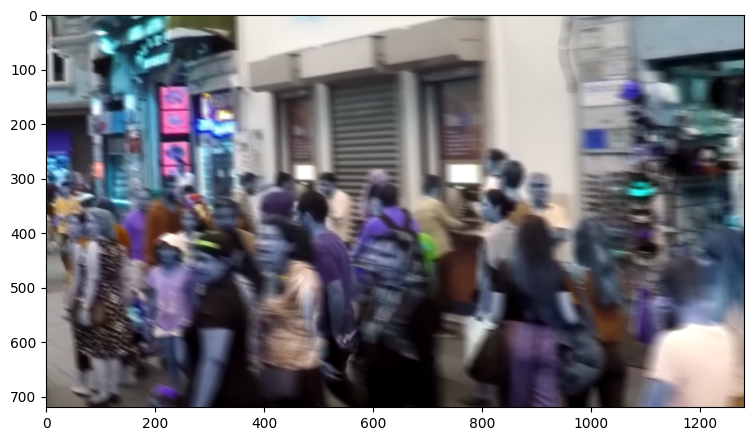

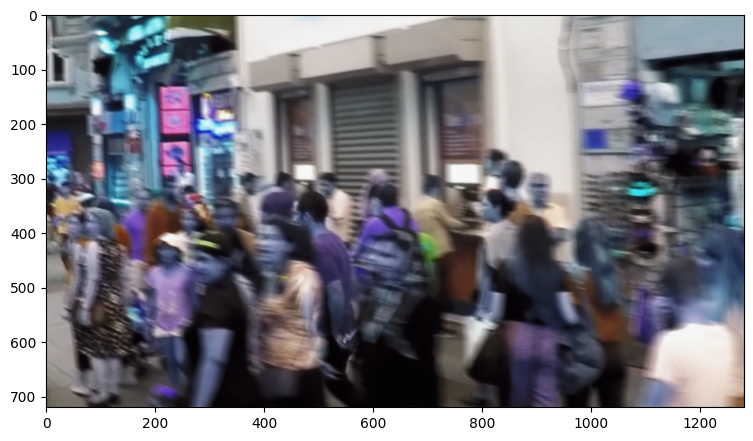

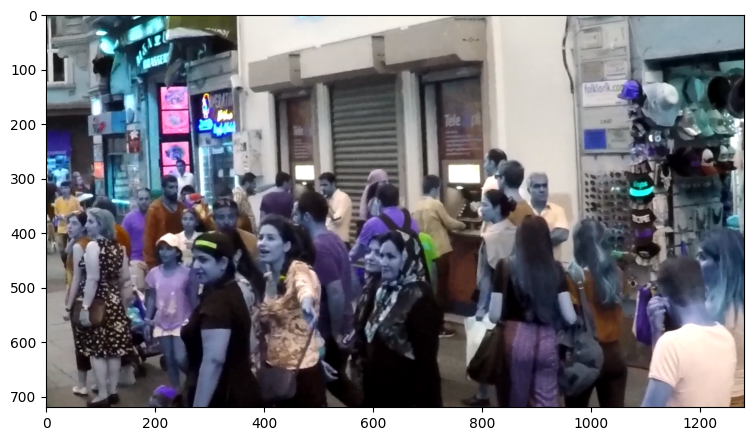

In [13]:
# Display blurred, predicted and sharp images
img_id = 0
display_blur_sharp_and_pred_images(img_id, blurred_test_batch, sharp_test_batch, predictions)